# **10x Visium colon ct-aware Harreman analysis**

This notebook reproduces the Fig 5G and 5H panels.

In [1]:
import harreman
import os
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import mplscience
from scipy.stats import zscore
from plotnine import *
import warnings
warnings.filterwarnings("ignore")


BASE_PATH = "/home/projects/nyosef/oier/Harreman_files/Visium_colon"
ADATA_PATH = os.path.join(BASE_PATH, 'h5ads')
DATA_PATH = os.path.join(BASE_PATH, 'data')
PLOTS_PATH = os.path.join(BASE_PATH, 'plots')

In [2]:
adata = harreman.read_h5ad(os.path.join(ADATA_PATH, 'Visium_colon_Harreman_unrolled.h5ad'))

In [3]:
st_adata = sc.read_h5ad(os.path.join(ADATA_PATH, 'Visium_colon_DestVI_v2_adata.h5ad'))

In [4]:
cell_types = [ct for ct in st_adata.obsm['proportions'].columns if 'additional' not in ct]
df_z = st_adata.obsm['proportions'][cell_types].apply(zscore, axis=0)
assigned_cell_types = df_z.idxmax(axis=1)
adata.obs['cell_type'] = assigned_cell_types

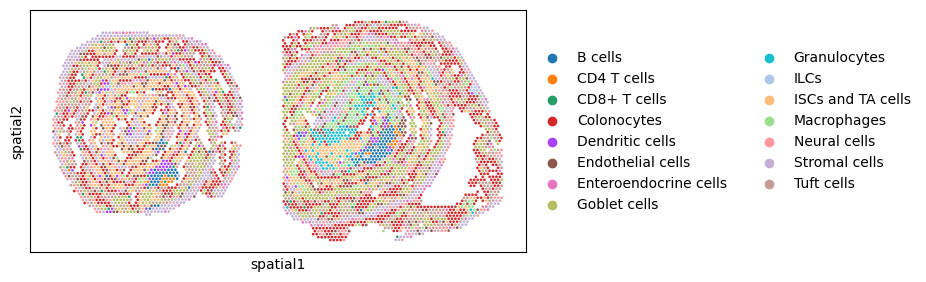

In [5]:
sc.pl.spatial(adata, color="cell_type", title='', spot_size=80)

In [6]:
cell_communication_df = adata.uns['ccc_results']['cell_com_df_gp_sig'].copy()

In [7]:
gene_pairs_per_metabolite = adata.uns['gene_pairs_per_metabolite']
    
def to_tuple(x):
    # Recursively convert lists to tuples
    if isinstance(x, list):
        return tuple(to_tuple(i) for i in x)
    return x

metabolite_gene_pair_df = pd.DataFrame.from_dict(gene_pairs_per_metabolite, orient="index").reset_index()
metabolite_gene_pair_df = metabolite_gene_pair_df.rename(columns={"index": "metabolite"})
metabolite_gene_pair_df['gene_pair'] = metabolite_gene_pair_df['gene_pair'].apply(
    lambda arr: [(to_tuple(gp[0]), to_tuple(gp[1])) for gp in arr]
)
metabolite_gene_pair_df['gene_type'] = metabolite_gene_pair_df['gene_type'].apply(
    lambda arr: [(to_tuple(gt[0]), to_tuple(gt[1])) for gt in arr]
)
metabolite_gene_pair_df = pd.concat([
    metabolite_gene_pair_df['metabolite'],
    metabolite_gene_pair_df.explode('gene_pair')['gene_pair'],
    metabolite_gene_pair_df.explode('gene_type')['gene_type'],
], axis=1).reset_index(drop=True)

if 'LR_database' in adata.uns:
    LR_database = adata.uns['LR_database']
    df_merged = pd.merge(metabolite_gene_pair_df, LR_database, left_on='metabolite', right_on='interaction_name', how='left')
    LR_df = df_merged.dropna(subset=['pathway_name'])
    metabolite_gene_pair_df['metabolite'][metabolite_gene_pair_df.metabolite.isin(LR_df.metabolite)] = LR_df['pathway_name']

In [8]:
metabolite_gene_pair_df = metabolite_gene_pair_df.set_index('metabolite')

In [9]:
metabolites = ['Sodium_calcium_potassium exchange', 'Creatine', 'Cholic acid', 'Adenosine triphosphate', 'Vitamin A', 'Lysophosphatidylcholine']

In [10]:
def is_present(row, gene_pairs):
    gene1, gene2 = row['Gene 1'], row['Gene 2']
    return any(
        (gene1 in pair and gene2 in pair) if isinstance(pair, tuple) else False
        for pair in gene_pairs
    )

gene_pairs = metabolite_gene_pair_df.loc[metabolites]['gene_pair'].tolist()
cell_communication_df_filt = cell_communication_df[cell_communication_df.apply(lambda row: is_present(row, gene_pairs), axis=1)]

In [11]:
gene_pairs_filt = list(zip(cell_communication_df_filt["Gene 1"], cell_communication_df_filt["Gene 2"]))

In [12]:
def harreman_pipeline(adata, gene_pairs_filt, metabolites, fix_gp, verbose=False):

    harreman.pp.extract_interaction_db(adata, species='mouse', database='both', verbose=verbose)
    
    harreman.tl.compute_knn_graph(adata,
                            compute_neighbors_on_key="spatial_unrolled", 
                            n_neighbors=5,
                            weighted_graph=False,
                            sample_key='cond',
                            verbose=verbose)
    
    harreman.tl.compute_gene_pairs(adata, cell_type_key='cell_type', verbose=verbose)
    
    gene_pairs_filt_tmp = [(x, list(y.split(' - ')) if ' - ' in y else y) for x, y in gene_pairs_filt]
    gene_pairs_filt_new = [(list(x.split(' - ')) if ' - ' in x else x, y) for x, y in gene_pairs_filt_tmp]
    
    harreman.tl.compute_ct_cell_communication(adata, model='danb', cell_type_key='cell_type', M = 1000, test = "both", layer_key_p_test='counts', layer_key_np_test='log_norm', subset_gene_pairs=gene_pairs_filt_new, subset_metabolites=metabolites, fix_gp=fix_gp, verbose=verbose)
    
    return adata

In [13]:
fix_gp = True
adata = harreman_pipeline(adata, gene_pairs_filt, metabolites, fix_gp, verbose=True)

Extracting interaction database...
Finished extracting interaction database in 17.645 seconds
Computing the neighborhood graph...
Restricting graph within samples using 'cond'...


100%|██████████| 2/2 [00:00<00:00, 115.40it/s]

Computing the weights...
Finished computing the KNN graph in 0.030 seconds
Computing gene pairs...


Finished computing gene pairs in 4.294 seconds
Starting cell type-aware cell-cell communication analysis...
Running the parametric test...
Running the non-parametric test...


Permutation test: 100%|██████████| 1000/1000 [01:47<00:00,  9.28it/s]


Non-parametric test finished.
Obtaining cell type-aware communication results...
Finished computing cell type-aware cell-cell communication analysis in 109.811 seconds


In [14]:
harreman.tl.select_significant_interactions(adata, test = "non-parametric", ct_aware = True, threshold = 0.05)

In [15]:
harreman.tl.compute_ct_interacting_cell_scores(adata, test = "both", verbose=True)

Computing cell type-aware gene pair and metabolite scores...
Running the parametric test...
Parametric test finished.
Running the non-parametric test...
Non-parametric test finished.
Finished computing cell type-aware gene pair and metabolite scores in 0.702 seconds


In [16]:
filename = f'{ADATA_PATH}/Visium_colon_ct_Harreman_no_deconv_fix_gp_adata.h5ad' if fix_gp else f'{ADATA_PATH}/Visium_colon_ct_Harreman_no_deconv_adata.h5ad'
harreman.write_h5ad(adata, filename = filename)

## Visualization

### Communication heat map

In [2]:
gp_adata = harreman.read_h5ad(f'{ADATA_PATH}/Visium_colon_ct_Harreman_no_deconv_fix_gp_adata.h5ad')
adata = harreman.read_h5ad(f'{ADATA_PATH}/Visium_colon_ct_Harreman_no_deconv_adata.h5ad')

In [4]:
harreman.tl.select_significant_interactions(gp_adata, test = "non-parametric", ct_aware = True, threshold = 0.05)
harreman.tl.select_significant_interactions(adata, test = "non-parametric", ct_aware = True, threshold = 0.01)

In [5]:
cell_com_df_m_sig_gp = gp_adata.uns['ct_ccc_results']['cell_com_df_m'].copy()
cell_com_df_m_sig = adata.uns['ct_ccc_results']['cell_com_df_m'].copy()

In [14]:
cell_types = ['Colonocytes', 'Endothelial cells', 'Granulocytes', 'ISCs and TA cells', 'Macrophages']

In [11]:
cell_com_df_m_sig[(cell_com_df_m_sig['metabolite'] == 'Vitamin A') & (cell_com_df_m_sig['selected'] == True)]

,Cell Type 1,Cell Type 2,metabolite,C_p,Z,Z_pval,Z_FDR,C_np,pval_np,FDR_np,selected
287,Colonocytes,ISCs and TA cells,Vitamin A,100.568695,1.556448,5.980082e-02,3.256844e-01,69.866714,0.000999,0.009306,True
383,Endothelial cells,Endothelial cells,Vitamin A,256.402802,7.252166,2.050788e-13,1.451958e-11,41.756870,0.000999,0.009306,True
401,Endothelial cells,Granulocytes,Vitamin A,262.869781,19.070578,2.216872e-81,3.923864e-79,75.407120,0.000999,0.009306,True
419,Endothelial cells,Macrophages,Vitamin A,16.081087,0.577650,2.817503e-01,7.630316e-01,22.256069,0.000999,0.009306,True
545,Granulocytes,Granulocytes,Vitamin A,310.829987,8.880857,3.317367e-19,3.355280e-17,448.291901,0.000999,0.009306,True


In [23]:
cell_com_df_m_sig_gp[(cell_com_df_m_sig_gp['metabolite'] == 'Vitamin A') & (cell_com_df_m_sig_gp['selected'] == True)]

,Cell Type 1,Cell Type 2,metabolite,C_p,Z,Z_pval,Z_FDR,C_np,pval_np,FDR_np,selected
245,Colonocytes,Colonocytes,Vitamin A,297.964020,2.874059,2.026168e-03,3.338520e-02,291.673492,0.000999,0.009558,True
383,Endothelial cells,Endothelial cells,Vitamin A,256.402802,2.324559,1.004777e-02,1.046150e-01,41.756870,0.002997,0.024673,True
401,Endothelial cells,Granulocytes,Vitamin A,262.869781,3.424167,3.083437e-04,8.085456e-03,75.407120,0.000999,0.009558,True
545,Granulocytes,Granulocytes,Vitamin A,310.829987,6.668528,1.291908e-11,1.306673e-09,448.291901,0.000999,0.009558,True
563,Granulocytes,Macrophages,Vitamin A,-39.275211,-2.162553,9.847122e-01,9.999323e-01,32.951523,0.000999,0.009558,True
623,ISCs and TA cells,ISCs and TA cells,Vitamin A,268.887543,2.548171,5.414476e-03,7.098979e-02,105.541183,0.005994,0.044206,True
653,Macrophages,Macrophages,Vitamin A,44.419670,0.897389,1.847557e-01,4.972480e-01,46.333382,0.000999,0.009558,True


In [24]:
cell_com_df_m_sig_gp[(cell_com_df_m_sig_gp['metabolite'] == 'Lysophosphatidylcholine') & (cell_com_df_m_sig_gp['selected'] == True)]

,Cell Type 1,Cell Type 2,metabolite,C_p,Z,Z_pval,Z_FDR,C_np,pval_np,FDR_np,selected
273,Colonocytes,Granulocytes,Lysophosphatidylcholine,23.766243,1.462516,0.071800,0.356446,3.091001,0.001998,0.017464,True
543,Granulocytes,Granulocytes,Lysophosphatidylcholine,-8.916992,-0.570577,0.715857,0.947339,6.079005,0.000999,0.009558,True
561,Granulocytes,Macrophages,Lysophosphatidylcholine,25.476925,1.208225,0.113480,0.436130,3.407326,0.000999,0.009558,True
621,ISCs and TA cells,ISCs and TA cells,Lysophosphatidylcholine,58.808617,1.609255,0.053780,0.312102,11.614038,0.000999,0.009558,True


In [15]:
cell_com_df_m_sig_gp = cell_com_df_m_sig_gp[(cell_com_df_m_sig_gp['Cell Type 1'].isin(cell_types)) & (cell_com_df_m_sig_gp['Cell Type 2'].isin(cell_types))]
cell_com_df_m_sig = cell_com_df_m_sig[(cell_com_df_m_sig['Cell Type 1'].isin(cell_types)) & (cell_com_df_m_sig['Cell Type 2'].isin(cell_types))]

In [16]:
cell_com_df_m_sig_full_gp = pd.concat([
    cell_com_df_m_sig_gp,
    cell_com_df_m_sig_gp.rename(columns={'Cell Type 1': 'Cell Type 2', 'Cell Type 2': 'Cell Type 1'})
], ignore_index=True).drop_duplicates()

cell_com_df_m_sig_full = pd.concat([
    cell_com_df_m_sig,
    cell_com_df_m_sig.rename(columns={'Cell Type 1': 'Cell Type 2', 'Cell Type 2': 'Cell Type 1'})
], ignore_index=True).drop_duplicates()

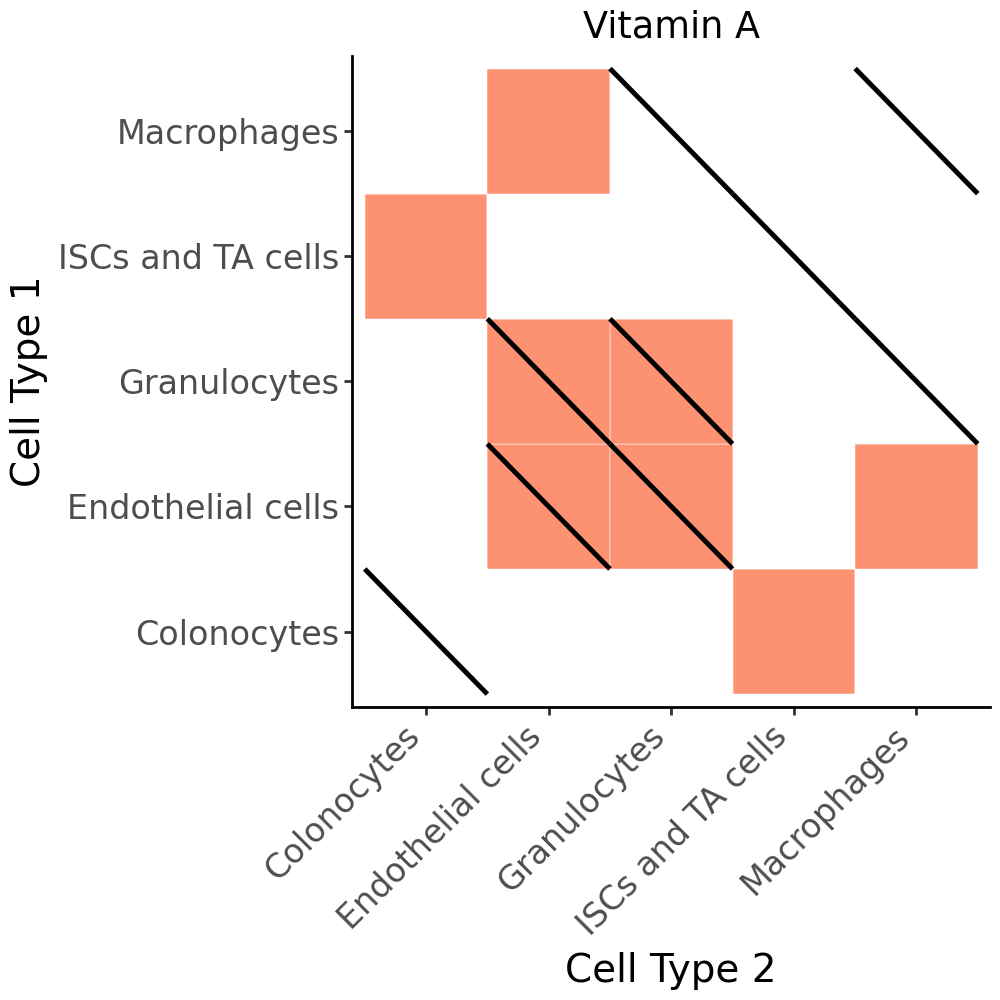

In [25]:
cell_com_df_m_sig_full_metab_gp = cell_com_df_m_sig_full_gp[cell_com_df_m_sig_full_gp['metabolite'] == 'Vitamin A'].copy()
cell_com_df_m_sig_full_metab = cell_com_df_m_sig_full[cell_com_df_m_sig_full['metabolite'] == 'Vitamin A'].copy()

diag_lines = cell_com_df_m_sig_full_metab_gp[cell_com_df_m_sig_full_metab_gp['selected']].copy()

# For plotting diagonal lines, define tile corners
diag_lines['x'] = diag_lines['Cell Type 2']
diag_lines['y'] = diag_lines['Cell Type 1']
diag_lines['xend'] = diag_lines['Cell Type 2']
diag_lines['yend'] = diag_lines['Cell Type 1']

# Map to numeric (for line coordinates)
val_sum = 0.5
x_order = {k: i+1 for i, k in enumerate(cell_types)}
diag_lines['x0'] = diag_lines['x'].map(x_order) - val_sum
diag_lines['x1'] = diag_lines['x'].map(x_order) + val_sum
diag_lines['y0'] = diag_lines['y'].map(x_order) - val_sum
diag_lines['y1'] = diag_lines['y'].map(x_order) + val_sum

p = (
    ggplot(cell_com_df_m_sig_full_metab, aes(x='Cell Type 2', y='Cell Type 1')) +
    # Base tiles
    geom_tile(aes(fill='selected'), color='white', show_legend=False) +
    scale_fill_manual(values={True: '#FC9272', False: 'white'}) +

    # Diagonal lines for second condition
    geom_segment(
        diag_lines,
        aes(x='x1', y='y0', xend='x0', yend='y1'),
        color='black',
        size=1
    ) +

    # Aesthetics
    theme_classic() +
    theme(axis_text_x=element_text(rotation=45, ha='right', size=12),
            axis_text_y=element_text(size=12),
            axis_title_x=element_text(size=14),
            axis_title_y=element_text(size=14),
            figure_size=(5, 5)) +
    labs(x='Cell Type 2', y='Cell Type 1', fill='-log10(FDR)', title='Vitamin A')
)
p
# p.save(os.path.join(PLOTS_PATH, 'Vitamin_A_ct_Harreman_heat_map_lines.svg'))

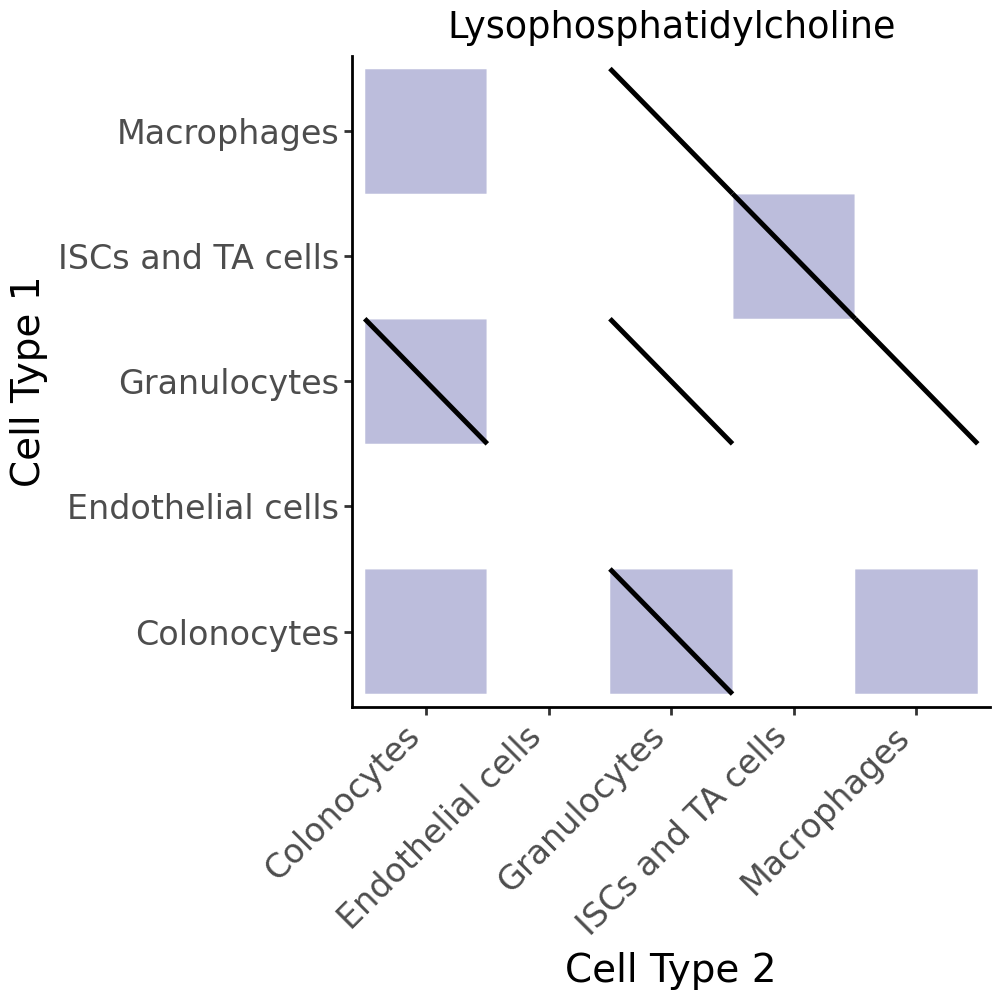

In [22]:
cell_com_df_m_sig_full_metab_gp = cell_com_df_m_sig_full_gp[cell_com_df_m_sig_full_gp['metabolite'] == 'Lysophosphatidylcholine'].copy()
cell_com_df_m_sig_full_metab = cell_com_df_m_sig_full[cell_com_df_m_sig_full['metabolite'] == 'Lysophosphatidylcholine'].copy()

diag_lines = cell_com_df_m_sig_full_metab_gp[cell_com_df_m_sig_full_metab_gp['selected']].copy()

# For plotting diagonal lines, define tile corners
diag_lines['x'] = diag_lines['Cell Type 2']
diag_lines['y'] = diag_lines['Cell Type 1']
diag_lines['xend'] = diag_lines['Cell Type 2']
diag_lines['yend'] = diag_lines['Cell Type 1']

# Map to numeric (for line coordinates)
val_sum = 0.5
x_order = {k: i+1 for i, k in enumerate(cell_types)}
diag_lines['x0'] = diag_lines['x'].map(x_order) - val_sum
diag_lines['x1'] = diag_lines['x'].map(x_order) + val_sum
diag_lines['y0'] = diag_lines['y'].map(x_order) - val_sum
diag_lines['y1'] = diag_lines['y'].map(x_order) + val_sum

p = (
    ggplot(cell_com_df_m_sig_full_metab, aes(x='Cell Type 2', y='Cell Type 1')) +
    # Base tiles
    geom_tile(aes(fill='selected'), color='white', show_legend=False) +
    scale_fill_manual(values={True: '#BCBDDC', False: 'white'}) +

    # Diagonal lines for second condition
    geom_segment(
        diag_lines,
        aes(x='x1', y='y0', xend='x0', yend='y1'),
        color='black',
        size=1
    ) +

    # Aesthetics
    theme_classic() +
    theme(axis_text_x=element_text(rotation=45, ha='right', size=12),
            axis_text_y=element_text(size=12),
            axis_title_x=element_text(size=14),
            axis_title_y=element_text(size=14),
            figure_size=(5, 5)) +
    labs(x='Cell Type 2', y='Cell Type 1', fill='-log10(FDR)', title='Lysophosphatidylcholine')
)
p
# p.save(os.path.join(PLOTS_PATH, 'Lysophosphatidylcholine_ct_Harreman_heat_map_lines.svg'))

### Cell type-aware interacting cell scores

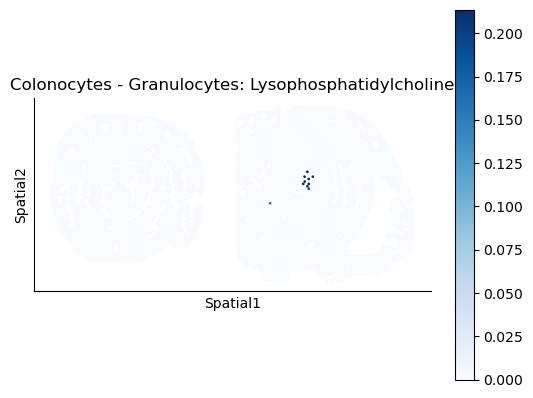

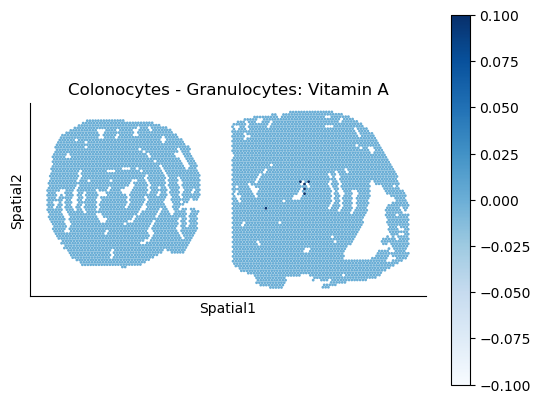

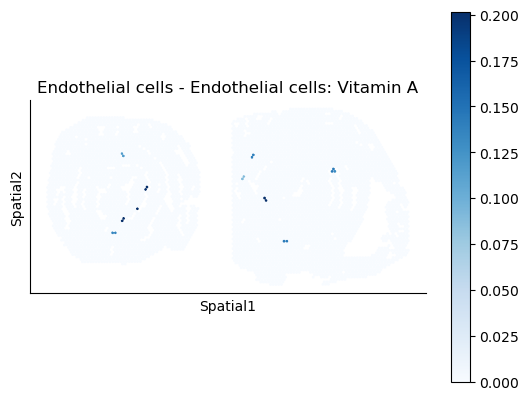

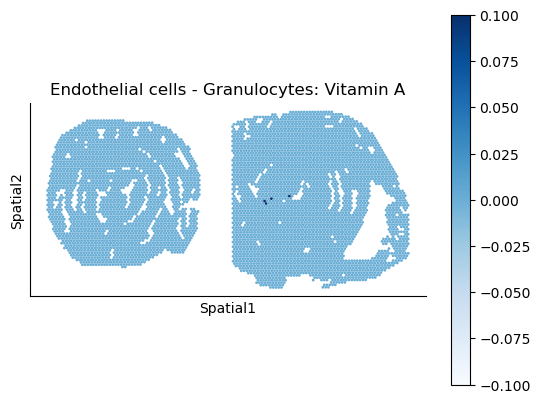

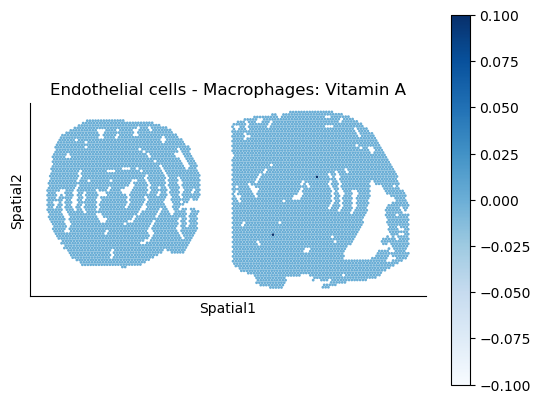

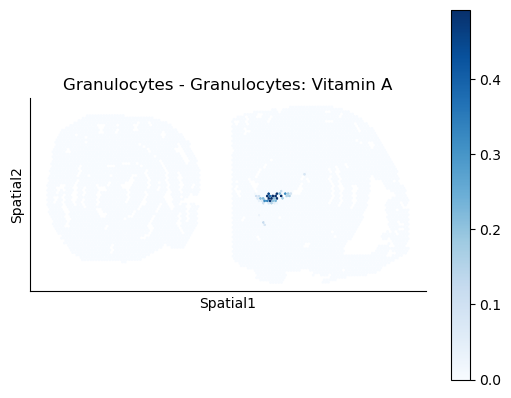

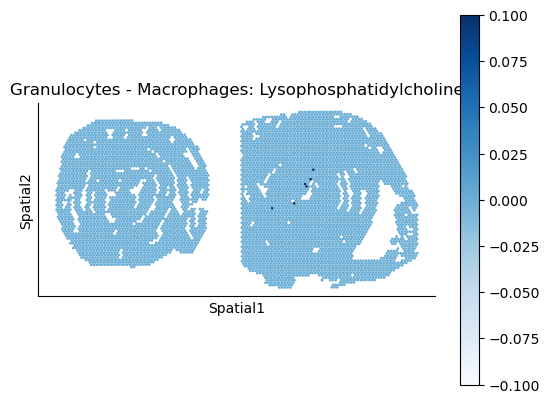

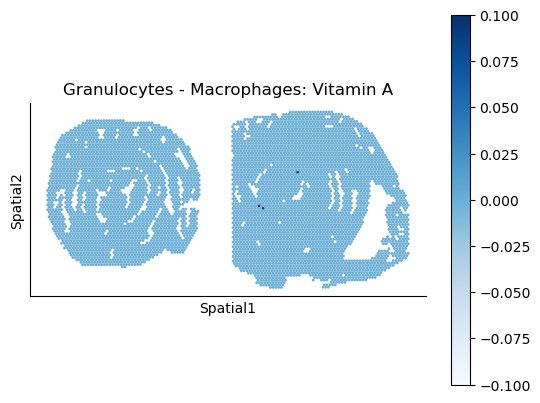

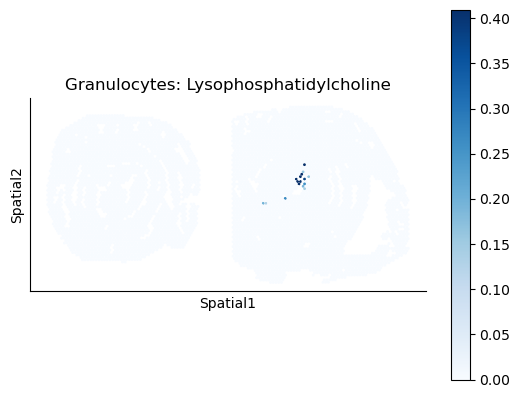

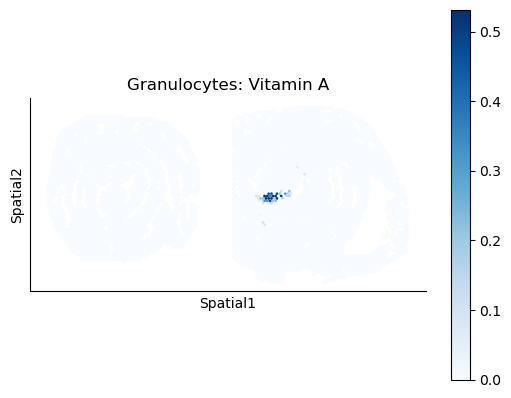

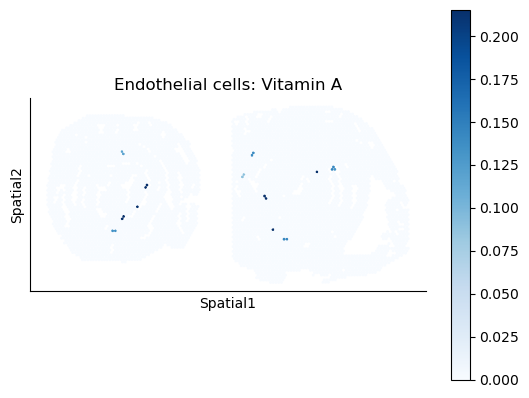

In [10]:
harreman.pl.plot_ct_interacting_cell_scores(adata, interactions=['Vitamin A', 'Lysophosphatidylcholine'], cell_type_pair=['Granulocytes', 'Endothelial cells'], test='non-parametric', coords_obsm_key='spatial', s=1, vmin=0, vmax='p99.9', normalize_values=True, cmap='Blues', swap_y_axis=True)

In [3]:
d0_adata = sc.read_h5ad(os.path.join(ADATA_PATH, 'Visium_colon_d0_adata.h5ad'))
d14_adata = sc.read_h5ad(os.path.join(ADATA_PATH, 'Visium_colon_d14_adata.h5ad'))

In [8]:
interacting_cell_scores_m = adata.obsm['ct_interacting_cell_results_np_m_cs_df']
interactions = ['Lysophosphatidylcholine', 'Vitamin A']
ct_pairs = ['Granulocytes']

def match_columns(df, ct_pairs, interactions):
    matched_columns = []
    per_cell_aggregation = {}
    for col in df.columns:
        ct_pair_str, interaction = col.split(': ', 1)
        if interaction not in interactions:
            continue
        if not ct_pairs:
            matched_columns.append(col)
            continue
        try:
            ct1, ct2 = ct_pair_str.split(' - ')
        except ValueError:
            continue  # skip malformed cell type pairs

        for query in ct_pairs:
            if ' - ' in query:
                # Exact match of cell type pair
                if query == f"{ct1} - {ct2}":
                    matched_columns.append(col)
                    break
            else:
                # Single cell type: match if in either position
                if query == ct1 or query == ct2:
                    matched_columns.append(col)
                    key = f"{query}: {interaction}"
                    if key not in per_cell_aggregation:
                        per_cell_aggregation[key] = df[col].copy()
                    else:
                        per_cell_aggregation[key] += df[col]
                    break

    selected_df = df[matched_columns]
    if per_cell_aggregation:
        agg_df = pd.concat(per_cell_aggregation, axis=1)
    else:
        agg_df = pd.DataFrame(index=df.index)  # empty fallback

    return selected_df, agg_df

m_selected, scores = match_columns(interacting_cell_scores_m, ct_pairs, interactions)
scores = scores.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

In [4]:
adata

AnnData object with n_obs × n_vars = 6168 × 13967
    obs: 'in_tissue', 'array_row', 'array_col', 'cond', 'id', 'row', 'col', 'layer', 'ord', 'dist', 'spot', 'pixel_x', 'pixel_y', 'Module 1', 'Module 2', 'Module 3', 'Module 4', 'Module 5', 'Module 6', 'Module 7', 'Module 8', 'Module 9', 'Module 10', 'top_super_module', 'dist_norm', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'local_autocorrelation'
    uns: 'D', 'LR_database', 'autocorrelation_filt', 'ccc_results', 'cell_type_colors', 'cell_type_key', 'cell_type_pairs', 'cell_types', 'cells', 'center_counts_for_np_test', 'cond_colors', 'cor_method', 'ct_ccc_results', 'ct_interacting_cell_results', 'database', 'database_varm_key', 'de_filt', 'exporter', 'expression_filt', 'gene_autocorrelation_results', 'gene_modules', 'gene_modules_dict', 'gene_modules_sm', 'gene_pair_dict', 'gene_pairs', 'gene_pairs_ind', 'gene_pairs_ind_per_ct_pair', 'gene_pairs_ind_per_ct_pair_sig', 'gene_pairs_per_ct_pair', 'gene_pairs_per_ct_pair_i

In [5]:
from matplotlib.colors import ListedColormap

In [6]:
cmap=sns.color_palette(["#08519C", "#FEE08B", "#EF3B2C"])
custom_cmap = ListedColormap(cmap)

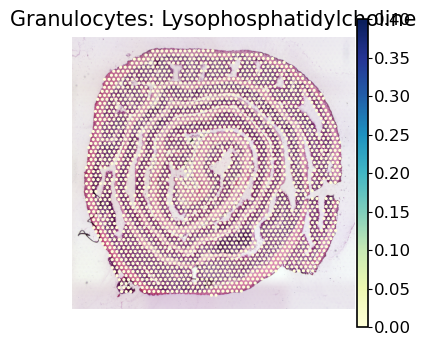

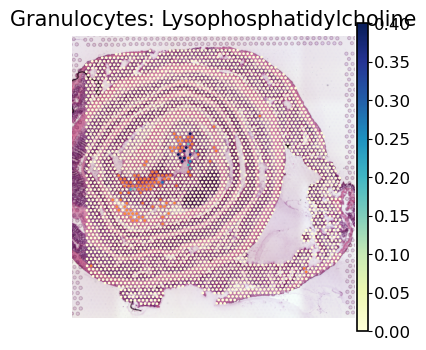

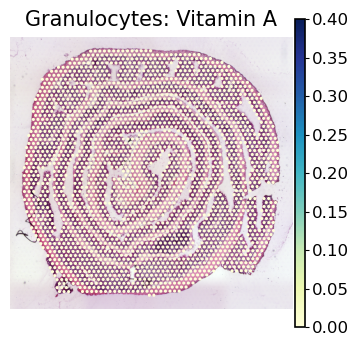

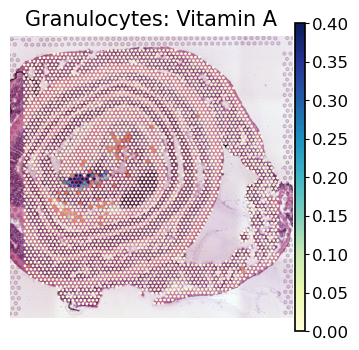

In [10]:
for interaction in scores.columns:
    p99 = np.percentile(scores[interaction], 99.9)
    p1 = np.percentile(scores[interaction], 1)
    for ad_ in [d0_adata, d14_adata]:
        with mplscience.style_context():
            cond = ad_.obs['cond'].cat.categories[0]
            if interaction not in ad_.obs.columns:
                ad_.obs[interaction] = scores[interaction]
            ad_.obs[interaction] = ad_.obs[interaction].fillna(0)
            ad_.obs['cell_type'] = adata.obs['cell_type']
            mask = (ad_.obs['cell_type'] == 'Granulocytes') & (ad_.obs[interaction] == 0)
            ad_.obs.loc[mask, interaction] = np.nan
            sc.pl.spatial(ad_, color=interaction, frameon=False, spot_size=70, img_key="hires", legend_loc=None, title=interaction, show=False, vmin=0, vmax=0.4, cmap='YlGnBu', na_color='#FD8D3C')
            # plt.savefig(os.path.join(PLOTS_PATH, f"{cond.replace(' ', '_')}_{interaction.replace(': ', '_').replace(' ', '_')}_score_HE_image.pdf"))